In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.

Using Barnes weight function to develop a background field to use in
the SOA.

INPUT:
- 500 hPa heights

OUTPUT:
- 500 hPa height analysis via SOA with N=2 stations, 4 stations, and 10 stations
- Plots of analysis increments for N=2, 4, and 10
- Text files of analysis differences
- Text file with RMS values


"""

__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

###
# EDITS MADE BY ALEC SCZEPANSKI FOR HOMEWORK PURPOSES

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

import pandas as pd

In [3]:
# Create function to do Barnes analysis:

def Barnes(ROI, d_ik):
    
    ''' 
    Function to analyze the value at a given point from other data
    using a Barnes analysis technique.
    
    INPUT:
    ROI_ratio = Radius of Influence
    d_ik = distance between i-th analysis point and k-th observation point
    
    OUTPUT:
    Barnes weight (w)
    '''
    
    # Establish constant for K_d:
    K_d = 10.8844524 #cm^2
    
    # Calculate 'w':
    if d_ik > ROI:
        
        w = 0
    
    else:
        
        w = np.exp((-(d_ik**2))/K_d)
        
    return w
    

In [4]:
### Create function for bilinear interpolation ###
     
    
def bilinear_interp(x, y, fA):
    
    '''
    Function to perform bilinear interpolation.
    
    INPUTS:
    x = indices of the x coordinate of the desired obs locations
    y = indices of the y coordinate of the desired obs locations
    fA = analysis values at the analysis points
    
    OUTPUT:
    F = resulting estimate analysis value at the obs location
    '''
    
    # Find local x, y indices to work with:
    local_x = x - np.floor(x)
    local_y = y - np.floor(y)
    
    # Find analysis values for the four corners of the box:
    F_1 = fA[int(np.floor(y)), int(np.floor(x))]
    F_2 = fA[int(np.ceil(y)), int(np.floor(x))]
    F_3 = fA[int(np.ceil(y)), int(np.ceil(x))]
    F_4 = fA[int(np.floor(y)), int(np.ceil(x))]
    
    # Next, will calculate the individual terms of the bilinear interpolation equation.
    # NOTE: The four corners of the square [(x_1, y_1), (x_1, y_2), (x_2, y_2), and (x_2, y_1)]
    # can be simplified to [(0,0), (0,1), (1,1), (1,0)] since we are worried about the local
    # indices, which are found via the local_x and local_y above. Thus, will plug in these
    # values for x_1, x_2, y_1, and y_2.
    
    # Calculate term 1 [(x - x_2)(y - y_2)F_1]
    T1 = (local_x - 1)*(local_y - 1)*F_1
    
    # Calculate term 2 [(x - x_1)(y - y_2)F_2]
    T2 = (local_x)*(local_y - 1)*F_2
    
    # Calculate term 3 [(x - x_1)(y - y_1)F_3]
    T3 = (local_x)*(local_y)*F_3
    
    # Calculate term 4 [(x - x_2)(y - y_1)F_4]
    T4 = (local_x - 1)*(local_y)*F_4
    
    # Now will combine these terms in the final equation. 
    # NOTE: The term 1/(dxdy) equals 1 in this case since dx = 1-0 and dy = 1-0, making dxdy = 1 and 1/dxdy = 1.
    # Thus, the term 1/(dxdy) is not shown below.
    
    F = (T1 - T2) + (T3 - T4)
    
    return F

In [5]:
# Create functions for first and subsequent passes:

def first_pass(w, f_O):
    
    '''
    Function to compute the first pass.
    Also used to help fill in data holes where obs are outside analysis domain in second and third passes.
    
    INPUTS:
    w: weights output from Barnes() function
    f_O: observations
    
    OUTPUT:
    f_A: analysis values
    '''
    
    w = np.array(w)
    
    f_A = np.nansum(w*f_O)/np.sum(w)
    
    return f_A

In [6]:
### Read in observations ###

# Establish column names:
col_names = ['station', 'latitude',
             'longitude', 'height',
             'wind_dir', 'wind_spd']

# Read in data:
df = pd.read_csv('RAOBs_201903131200.txt',
                 names = col_names)

# Establish variables:
station_id = df['station']
latitude = df['latitude']
longitude = df['longitude']
height = df['height']
dd = df['wind_dir']
ff = df['wind_spd']

### Set up analysis map with a 22x28 rectangular grid of points ###

# Some constants:
dx = 1.27 #in cm
dy = 1.27 #in cm
x_0 = 18.9 #in cm; upper left corner
y_0 = -6.3 #in cm; upper left corner

# Set up x and y intervals for grid:
x_i = x_0 + (np.arange(22)*dx)
y_j = y_0 + (np.arange(28)*dy)

# Combine x_i and y_j into a grid:
x_grid, y_grid = np.meshgrid(x_i, y_j)

### convert obs lat/long to x,y ###

# Convert observation lat and lon to x and y coordinates:
R = 637100000 #radius of Earth in centimeters
phi_O_rad = 60*(np.pi/180) #standard latitude in radians
lam_O = -115*(np.pi/180) #reference longitude in radians
m = 1/15000000 #map projection
lat_rad = latitude*(np.pi/180) #latitudes in radians
lon_rad = longitude*(np.pi/180) #Longitude in radians
sigma = (1 + np.sin(phi_O_rad))/(1 + np.sin(lat_rad))


# Calculate observation lat, lon in x, y coordinates:
r = m*(R*sigma*np.cos(lat_rad))
x_obs = r*(np.cos(lon_rad - lam_O))
y_obs = r*(np.sin(lon_rad - lam_O))


In [7]:
# Make array to save analysis values into:

# First pass
fB_ri = np.full((len(y_j), len(x_i)), -999.9)

In [8]:
### First analysis, no successive corrections ###

# Establish ROI:
ROI = 12.7775892

# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (X_k**2 + Y_k**2)**(1/2)
            
        # Create empty lists to store outputs from Barnes weighting:
        w = []
        
        # Loop through d_ik:
        for k in d_ik:
            
            w += [Barnes(ROI = ROI, d_ik = k)]
            
        
        fB_ri[i][j] = first_pass(w, height)

In order to find distances between points, will use following formula:

$d_{km} = d_{cm} * (1/m) * (1 [km] / 100,000 [m])$

where:
- d_km = distance between two points in km
- d_cm = distance between two points on the map in cm
- 1/m = the reciprocal of the map scale = 15,000,000
- 1 [km] / 100,000 [m] = conversion from cm to km

Eventually, will divide once more by 1000 to get thousands of km (e.g. 2000 km --> 2 thousands of km)

Will plug this in for 's' in Schlatter's correlations model formula:

$\rho(s) = 0.95exp(-1.24s^2)$

**However**, this formula is w.r.t. a standard latitude of 40 degrees. Our map is at 60 degrees. Thus, will find new range factor by doing the following:

$b = [(1+sin(40)) / (1+sin(60))] * 1.24$

Will plug in `b` in place of 1.24 in the equation for $\rho(s)$.

In [9]:
phi_one = (np.pi/180)*40
phi_two = (np.pi/180)*60

b = ((1+np.sin(phi_one))/(1+np.sin(phi_two)))*1.24

print(b)

1.0916553611113793


## N = 2

Want to solve the following equation:

$W = R_{kl}^{-1} * R_{ik}$

where:
- $R_{kl}$ is a 2x2 matrix of correlations between the k-th and l-th observations locations
- $R_{ik}$ is a 1x2 vector of correlations between the i-th analysis gridpoint and k-th observation location
- $W$ is a 1x2 vector of resulting weights.

In [10]:
# Establish array to save analysis:
fA_ri_N2 = np.full((len(y_j), len(x_i)), -999.9)

In [11]:
# Determine index values for x_obs and y_obs:
x_index = (x_obs - x_0) / 1.27
y_index = (y_obs - y_0) / 1.27


# Loop through gridded points and find where two closest obs are:
for i in range(len(x_grid)):
    for j in range (len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates:
        x_k = x_grid[i][j] - x_obs
        y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (x_k**2 + y_k**2)**(1/2)
        
        # Sort indices based off of how far away obs are from analysis point:
        indices = np.argsort(d_ik)
        
        # Pull two closest d_ik's
        d_ik_1 = d_ik[indices[0]]
        d_ik_2 = d_ik[indices[1]]
        
        # Convert d_ik_1 and d_ik_2 from cm to distance on Earth
        # in 1000s of km:
        d_ik_1 = d_ik_1*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_2 = d_ik_2*(15*(10**6))*(1/100000)*(1/1000)
        
        # Establish array for R_ik:
        R_ik = np.zeros((2,1))
        
        # Calculate correlations:
        R_ik[0,0] = 0.95*np.exp(-b*(d_ik_1**2))
        R_ik[1,0] = 0.95*np.exp(-b*(d_ik_2**2))
        
        
        # Now, will find distance between the two obs points:
        obs_x_1 = x_obs[indices[0]]
        obs_y_1 = y_obs[indices[0]]
        
        obs_x_2 = x_obs[indices[1]]
        obs_y_2 = y_obs[indices[1]]
        
        d_obs_x = obs_x_1 - obs_x_2
        d_obs_y = obs_y_1 - obs_y_2
        
        
        mag_d_obs = (d_obs_x**2 + d_obs_y **2)**(1/2)
        
        # Convert mag_d_obs from cm to distance on Earth:
        mag_d_obs = mag_d_obs*(15*(10**6))*(1/100000)*(1/1000)
        
        # Establish array for a row of R_kl:
        R_kl = np.zeros((2,2))
        
        # Calculate correlations:
        R_kl[0,0] = 1 #Correlation between a point and itself = 1
        R_kl[1,0] = 0.95*np.exp(-b*(mag_d_obs**2))
        R_kl[0,1] = 0.95*np.exp(-b*(mag_d_obs**2))
        R_kl[1,1] = 1

        
        # Calculate weights:
        w_ik = np.matmul(np.linalg.inv(R_kl), R_ik)
        
        # Next, use bilinear interpolation to calculate fB_rk (fA_rk)
        # (analysis values at the observations points):
        x_ind = [indices[0], indices[1]]
        
        # Temp list for fA_rk:
        fA_rk = []
        
        for ii in x_ind:
            if (0 < x_index[ii] < 21) and (0 < y_index[ii] < 27):
            
                p = bilinear_interp(x_index[ii],
                                   y_index[ii],
                                   fB_ri)
            
            # If observation is NOT within the domain, perform Barnes:
            else:
                local_x = x_obs[ii] - x_grid
                local_y = y_obs[ii] - y_grid
                
                # Get local d_ik:
                local_d_ik = ((local_x**2 + local_y**2)**(1/2))
                
                # Find obs points where there are analysis points are within ROI (4*d_min):
                indices_in_ROI = np.where(local_d_ik <= ROI)

                # Establish array to hold weights:
                local_weights = np.zeros((x_grid.shape))

                # Loop through found points:
                for jj in indices_in_ROI[0]:
                    for kk in indices_in_ROI[1]:

                        local_weights[jj][kk] = Barnes(ROI = ROI, d_ik = local_d_ik[jj][kk])

                p = first_pass(local_weights, fB_ri)

            fA_rk += [p]

        # Make an array for fA_rk:
        fB_rk_arr = np.zeros((2,1))

        # Append fA_rk to array:
        fB_rk_arr[0][0] = fA_rk[0]
        fB_rk_arr[1][0] = fA_rk[1]
                                                     
        # Perform product, then sum up the terms in the resulting matrix:
        fO_rk = np.array([
            [height[indices[0]]],
            [height[indices[1]]]
        ])
        
        w_ik = w_ik.flatten()
        fO_rk = fO_rk.flatten()
        fB_rk_arr = fB_rk_arr.flatten()
        
        summation = w_ik*(fO_rk - fB_rk_arr)
        summation = np.nansum(summation)
        
        # Calculate fA_ri_N2 and append:
        fA_ri_N2[i][j] = fB_ri[i][j] + summation
                                                     

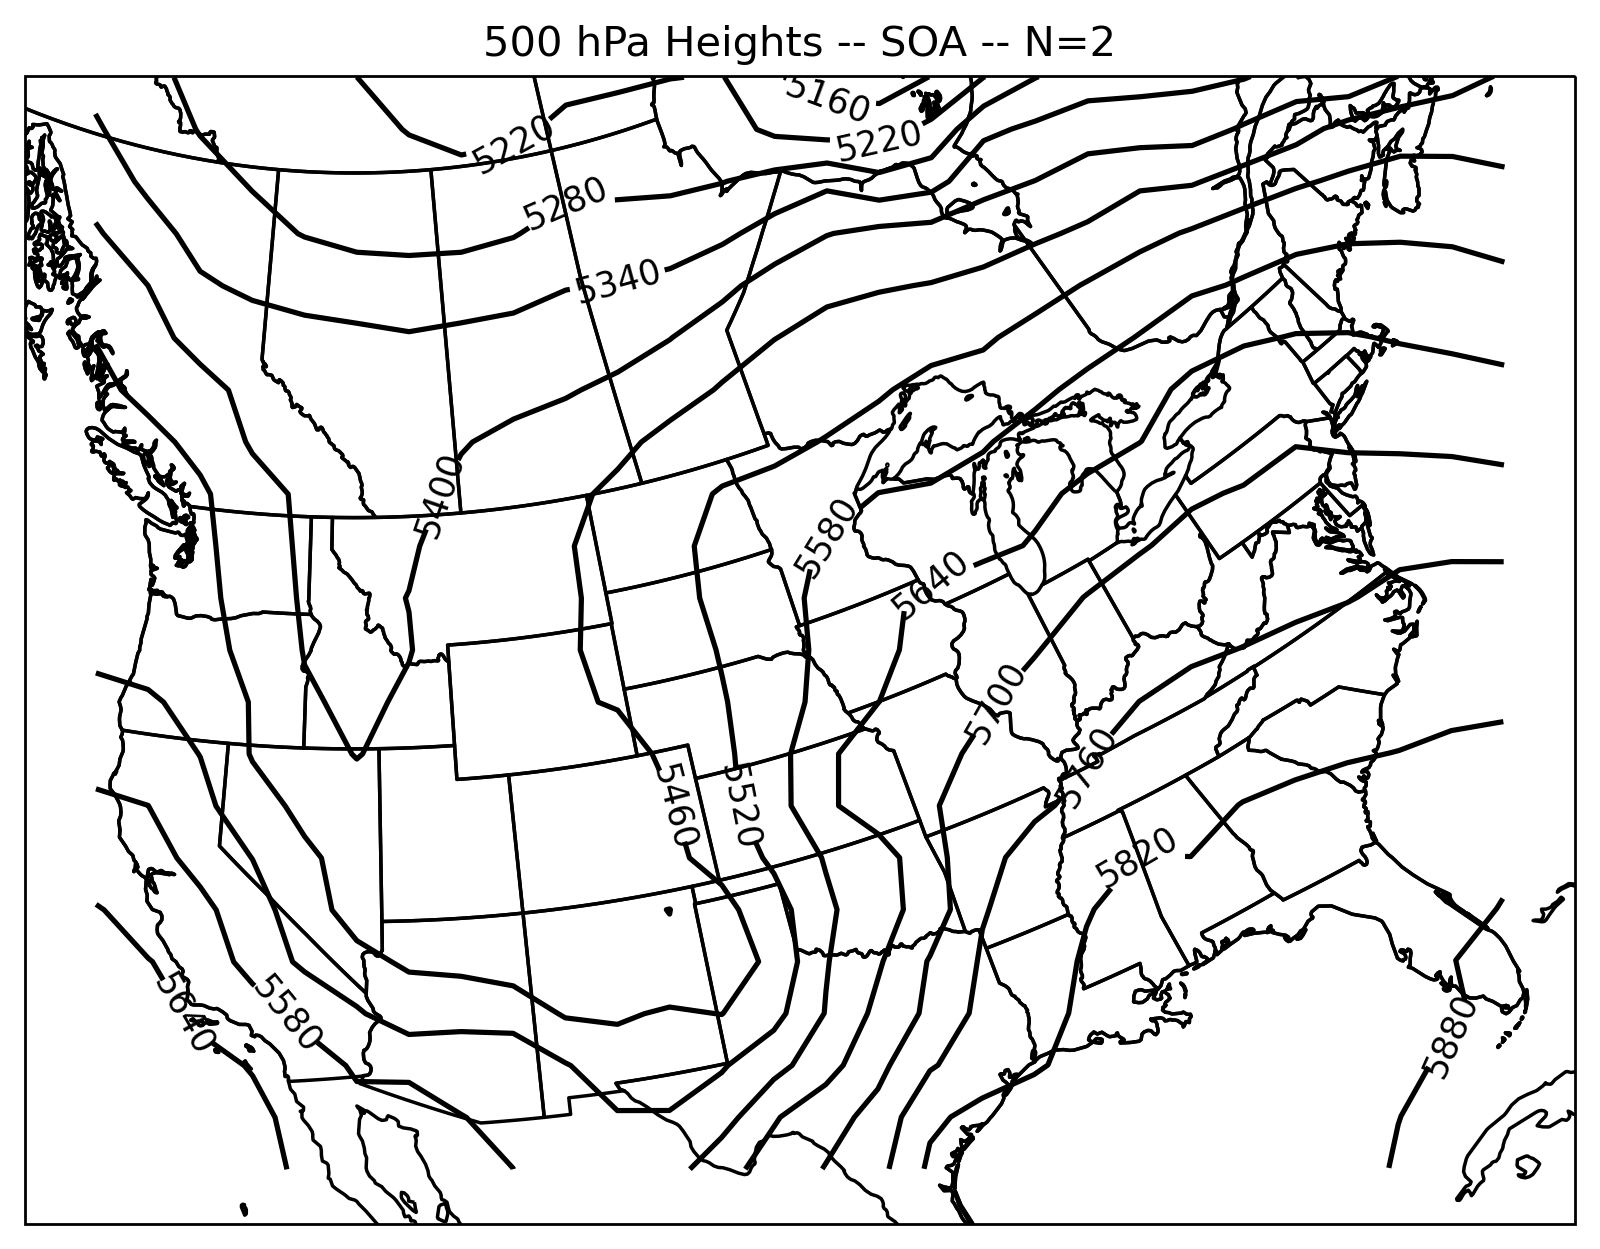

In [12]:
# Convert gridded points to phi and lambda (lat, lon):
phi_grid = (np.pi/2) - (2*(np.arctan(np.sqrt((x_grid / m)**2 + (y_grid / m)**2) / (R*(1 + np.sin(phi_O_rad))))))
phi_grid = phi_grid * (180/np.pi)
lam_grid = (lam_O + np.arctan(y_grid/x_grid)) * (180/np.pi)

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)

######################
# N = 2
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(lam_grid,phi_grid,fA_ri_N2,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights -- SOA -- N=2')

plt.savefig('Sczepanski_ATSC528_HW3_500hts_N2.png', dpi = 250)


---

## N = 4

Want to solve the following equation:

$W = R_{kl}^{-1} * R_{ik}$

where:
- $R_{kl}$ is a 4x4 matrix of correlations between the k-th and l-th observations locations
- $R_{ik}$ is a 1x4 vector of correlations between the i-th analysis gridpoint and k-th observation location
- $W$ is a 1x4 vector of resulting weights.

In [13]:
# Establish array to save analysis:
fA_ri_N4 = np.full((len(y_j), len(x_i)), -999.9)

In [14]:
# Determine index values for x_obs and y_obs:
x_index = (x_obs - x_0) / 1.27
y_index = (y_obs - y_0) / 1.27


# Loop through gridded points and find where two closest obs are:
for i in range(len(x_grid)):
    for j in range (len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates:
        x_k = x_grid[i][j] - x_obs
        y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (x_k**2 + y_k**2)**(1/2)
        
        # Sort indices based off of how far away obs are from analysis point:
        indices = np.argsort(d_ik)
        
        # Pull four closest d_ik's
        d_ik_1 = d_ik[indices[0]]
        d_ik_2 = d_ik[indices[1]]
        d_ik_3 = d_ik[indices[2]]
        d_ik_4 = d_ik[indices[3]]
        
        # Convert d_ik_1 thru d_ik_4 from cm to distance on Earth
        # in 1000s of km:
        d_ik_1 = d_ik_1*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_2 = d_ik_2*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_3 = d_ik_3*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_4 = d_ik_4*(15*(10**6))*(1/100000)*(1/1000)
        
        
        # Establish array for R_ik:
        R_ik = np.zeros((4,1))
        
        # Calculate correlations:
        R_ik[0,0] = 0.95*np.exp(-b*(d_ik_1**2))
        R_ik[1,0] = 0.95*np.exp(-b*(d_ik_2**2))
        R_ik[2,0] = 0.95*np.exp(-b*(d_ik_3**2))
        R_ik[3,0] = 0.95*np.exp(-b*(d_ik_4**2))
        
        # Now, will find distance between the four obs points:
        mag_obs = np.zeros((4,4))
        
        for ii in range(len(R_ik)):
            for jj in range(len(R_ik)):
                
                obs_x_1 = x_obs[indices[ii]]
                obs_y_1 = y_obs[indices[ii]]

                obs_x_2 = x_obs[indices[jj]]
                obs_y_2 = y_obs[indices[jj]]

                d_obs_x = obs_x_1 - obs_x_2
                d_obs_y = obs_y_1 - obs_y_2


                mag_d_obs = (d_obs_x**2 + d_obs_y **2)**(1/2)

                # Convert mag_d_obs from cm to distance on Earth:
                mag_d_obs = mag_d_obs*(15*(10**6))*(1/100000)*(1/1000)
                
                mag_obs[ii][jj] = mag_d_obs
                mag_obs[jj][ii] = mag_d_obs
        
        
        # Calculate correlations:
        R_kl = np.zeros((4,4))
        
        for ii in range(len(mag_obs)):
            for jj in range(len(mag_obs[ii])):
                
                if mag_obs[ii][jj] == 0:
                    
                    R_kl[ii][jj] = 1
                    
                else:
                    
                    R_kl[ii][jj] = 0.95*np.exp(-b*(mag_obs[ii][jj]**2))
                    
        
        # Calculate weights:
        w_ik = np.matmul(np.linalg.inv(R_kl), R_ik)
        
        # Next, use bilinear interpolation to calculate fB_rk1 thru fB_rk4
        # (analysis values at the observations points of the four points
        # found here):
        x_ind = [indices[0], indices[1], indices[2], indices[3]]
        
        # Temp list for fA_rk:
        fA_rk = []
        
        for ii in x_ind:
            
            if (0 < x_index[ii] < 21) and (0 < y_index[ii] < 27):
            
                p = bilinear_interp(x_index[ii],
                                   y_index[ii],
                                   fB_ri)
            
            # If observation is NOT within the domain, perform Barnes:
            else:
                local_x = x_obs[ii] - x_grid
                local_y = y_obs[ii] - y_grid
                
                # Get local d_ik:
                local_d_ik = ((local_x**2 + local_y**2)**(1/2))
                
                # Find obs points where there are analysis points are within ROI:
                indices_in_ROI = np.where(local_d_ik <= ROI)

                # Establish array to hold weights:
                local_weights = np.zeros((x_grid.shape))

                # Loop through found points:
                for jj in indices_in_ROI[0]:
                    for kk in indices_in_ROI[1]:

                        local_weights[jj][kk] = Barnes(ROI = ROI, d_ik = local_d_ik[jj][kk])

                p = first_pass(local_weights, fB_ri)

            fA_rk += [p]
                                                     
        # Make an array for fA_rk:
        fB_rk_arr = np.zeros((4,1))

        # Append fA_rk to array:
        fB_rk_arr[0][0] = fA_rk[0]
        fB_rk_arr[1][0] = fA_rk[1]
        fB_rk_arr[2][0] = fA_rk[2]
        fB_rk_arr[3][0] = fA_rk[3]
                                                     
        # Perform product, then sum up the terms in the resulting matrix:
        fO_rk = np.array([
            [height[indices[0]]],
            [height[indices[1]]],
            [height[indices[2]]],
            [height[indices[3]]]
        ])
        
        summation = w_ik*(fO_rk - fB_rk_arr)
        summation = np.nansum(summation)
        
        # Calculate fA_ri_N2 and append:
        fA_ri_N4[i][j] = fB_ri[i][j] + summation

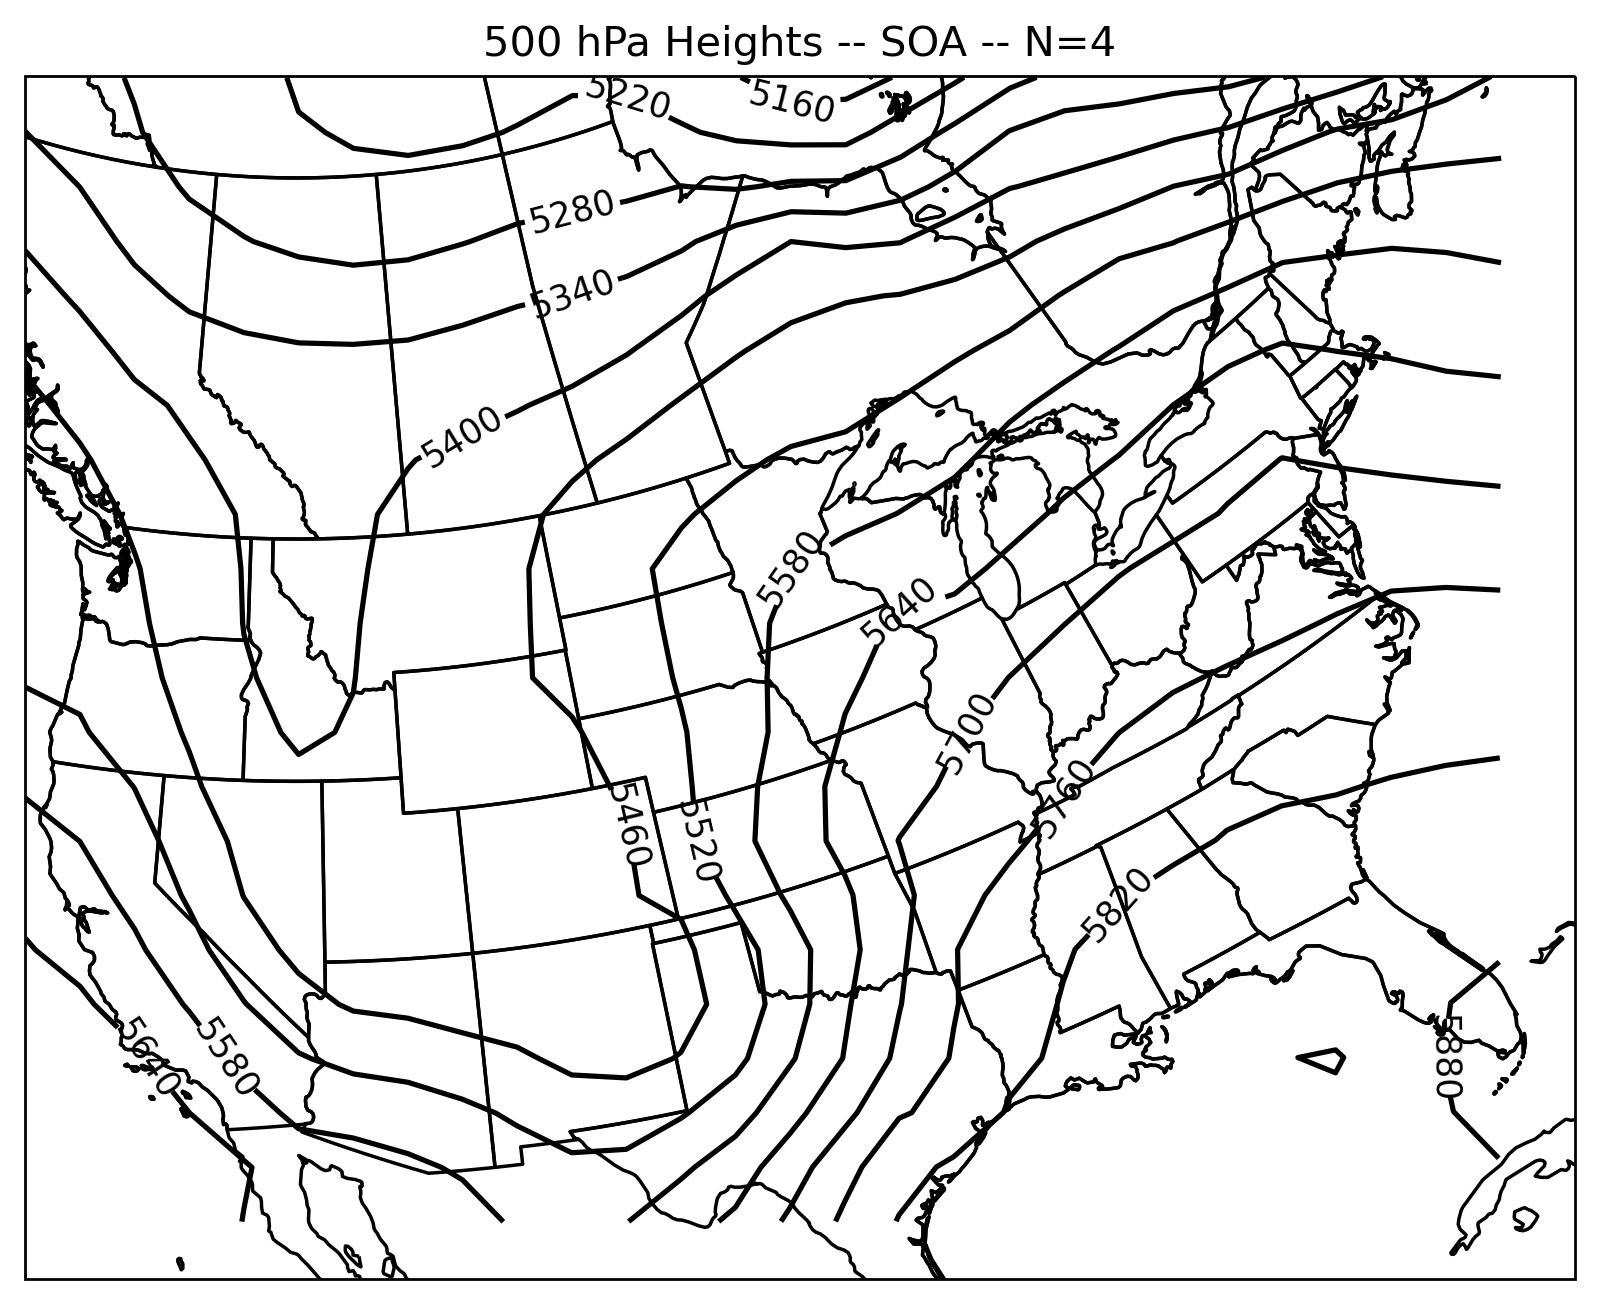

In [15]:
# PLOT

######################
# N = 4
fig = plt.figure(figsize=(8,8),dpi=250)
ax2 = fig.add_subplot(111,projection=proj)
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.COASTLINE)

cs2 = ax2.contour(lam_grid,phi_grid,fA_ri_N4,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs2,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights -- SOA -- N=4')

plt.savefig('Sczepanski_ATSC528_HW3_500hts_N4.png', dpi = 250)


---

## N = 10

Want to solve the following equation:

$W = R_{kl}^{-1} * R_{ik}$

where:
- $R_{kl}$ is a 10x10 matrix of correlations between the k-th and l-th observations locations
- $R_{ik}$ is a 1x10 vector of correlations between the i-th analysis gridpoint and k-th observation location
- $W$ is a 1x10 vector of resulting weights.

In [16]:
# Establish array to save analysis:
fA_ri_N10 = np.full((len(y_j), len(x_i)), -999.9)

In [ ]:
# Determine index values for x_obs and y_obs:
x_index = (x_obs - x_0) / 1.27
y_index = (y_obs - y_0) / 1.27


# Loop through gridded points and find where two closest obs are:
for i in range(len(x_grid)):
    for j in range (len(x_grid[i])):
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates:
        x_k = x_grid[i][j] - x_obs
        y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        d_ik = (x_k**2 + y_k**2)**(1/2)
        
        # Sort indices based off of how far away obs are from analysis point:
        indices = np.argsort(d_ik)
        
        # Pull ten closest d_ik's
        d_ik_1 = d_ik[indices[0]]
        d_ik_2 = d_ik[indices[1]]
        d_ik_3 = d_ik[indices[2]]
        d_ik_4 = d_ik[indices[3]]
        d_ik_5 = d_ik[indices[4]]
        d_ik_6 = d_ik[indices[5]]
        d_ik_7 = d_ik[indices[6]]
        d_ik_8 = d_ik[indices[7]]
        d_ik_9 = d_ik[indices[8]]
        d_ik_10 = d_ik[indices[9]]
       
        
        # Convert d_ik_1 thru d_ik_10 from cm to distance on Earth
        # in 1000s of km:
        d_ik_1 = d_ik_1*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_2 = d_ik_2*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_3 = d_ik_3*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_4 = d_ik_4*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_5 = d_ik_5*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_6 = d_ik_6*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_7 = d_ik_7*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_8 = d_ik_8*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_9 = d_ik_9*(15*(10**6))*(1/100000)*(1/1000)
        d_ik_10 = d_ik_10*(15*(10**6))*(1/100000)*(1/1000)
        
        # Establish array for R_ik:
        R_ik = np.zeros((10,1))
        
        # Calculate correlations:
        R_ik[0,0] = 0.95*np.exp(-b*(d_ik_1**2))
        R_ik[1,0] = 0.95*np.exp(-b*(d_ik_2**2))
        R_ik[2,0] = 0.95*np.exp(-b*(d_ik_3**2))
        R_ik[3,0] = 0.95*np.exp(-b*(d_ik_4**2))
        R_ik[4,0] = 0.95*np.exp(-b*(d_ik_5**2))
        R_ik[5,0] = 0.95*np.exp(-b*(d_ik_6**2))
        R_ik[6,0] = 0.95*np.exp(-b*(d_ik_7**2))
        R_ik[7,0] = 0.95*np.exp(-b*(d_ik_8**2))
        R_ik[8,0] = 0.95*np.exp(-b*(d_ik_9**2))
        R_ik[9,0] = 0.95*np.exp(-b*(d_ik_10**2))
        
        # Now, will find distance between the two obs points:
        mag_obs = np.zeros((10,10))
        
        for ii in range(len(R_ik)):
            for jj in range(len(R_ik)):
                
                obs_x_1 = x_obs[indices[ii]]
                obs_y_1 = y_obs[indices[ii]]

                obs_x_2 = x_obs[indices[jj]]
                obs_y_2 = y_obs[indices[jj]]

                d_obs_x = obs_x_1 - obs_x_2
                d_obs_y = obs_y_1 - obs_y_2


                mag_d_obs = (d_obs_x**2 + d_obs_y **2)**(1/2)

                # Convert mag_d_obs from cm to distance on Earth:
                mag_d_obs = mag_d_obs*(15*(10**6))*(1/100000)*(1/1000)
                
                mag_obs[ii][jj] = mag_d_obs
                mag_obs[jj][ii] = mag_d_obs
        
        
        # Calculate correlations:
        R_kl = np.zeros((10,10))
        
        for ii in range(len(mag_obs)):
            for jj in range(len(mag_obs[ii])):
                
                if mag_obs[ii][jj] == 0:
                    
                    R_kl[ii][jj] = 1
                    
                else:
                    
                    R_kl[ii][jj] = 0.95*np.exp(-b*(mag_obs[ii][jj]**2))
                    
        
        # Calculate weights:
        w_ik = np.matmul(np.linalg.inv(R_kl), R_ik)
        
        # Next, use bilinear interpolation to calculate fB_rk1 thru fB_rk10
        # (analysis values at the observations points of the ten points
        # found here):
        x_ind = [indices[0], indices[1], indices[2], indices[3],
                indices[4], indices[5], indices[6], indices[7],
                indices[8], indices[9]]
        
        # Temp list for fA_rk:
        fA_rk = []
        
        for ii in x_ind:
            
            if (0 < x_index[ii] < 21) and (0 < y_index[ii] < 27):
            
                p = bilinear_interp(x_index[ii],
                                   y_index[ii],
                                   fB_ri)
            
            # If observation is NOT within the domain, perform Barnes:
            else:
                local_x = x_obs[ii] - x_grid
                local_y = y_obs[ii] - y_grid
                
                # Get local d_ik:
                local_d_ik = ((local_x**2 + local_y**2)**(1/2))
                
                # Find obs points where there are analysis points are within ROI:
                indices_in_ROI = np.where(local_d_ik <= ROI)

                # Establish array to hold weights:
                local_weights = np.zeros((x_grid.shape))

                # Loop through found points:
                for jj in indices_in_ROI[0]:
                    for kk in indices_in_ROI[1]:

                        local_weights[jj][kk] = Barnes(ROI = ROI, d_ik = local_d_ik[jj][kk])

                p = first_pass(local_weights, fB_ri)

            fA_rk += [p]
                                                     
        # Make an array for fA_rk:
        fB_rk_arr = np.zeros((10,1))

        # Append fA_rk to array:
        fB_rk_arr[0][0] = fA_rk[0]
        fB_rk_arr[1][0] = fA_rk[1]
        fB_rk_arr[2][0] = fA_rk[2]
        fB_rk_arr[3][0] = fA_rk[3]
        fB_rk_arr[4][0] = fA_rk[4]
        fB_rk_arr[5][0] = fA_rk[5]
        fB_rk_arr[6][0] = fA_rk[6]
        fB_rk_arr[7][0] = fA_rk[7]
        fB_rk_arr[8][0] = fA_rk[8]
        fB_rk_arr[9][0] = fA_rk[9]
                                                     
        # Perform product, then sum up the terms in the resulting matrix:
        fO_rk = np.array([
            [height[indices[0]]],
            [height[indices[1]]],
            [height[indices[2]]],
            [height[indices[3]]],
            [height[indices[4]]],
            [height[indices[5]]],
            [height[indices[6]]],
            [height[indices[7]]],
            [height[indices[8]]],
            [height[indices[9]]]
        ])
        
        summation = w_ik*(fO_rk - fB_rk_arr)
        summation = np.nansum(summation)
        
        # Calculate fA_ri_N2 and append:
        fA_ri_N10[i][j] = fB_ri[i][j] + summation

In [ ]:
# PLOT

######################
# N = 10
fig = plt.figure(figsize=(8,8),dpi=250)
ax3 = fig.add_subplot(111,projection=proj)
ax3.add_feature(cfeature.STATES)
ax3.add_feature(cfeature.COASTLINE)

cs3 = ax3.contour(lam_grid,phi_grid,fA_ri_N10,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs3,levels=np.arange(0,8000,60))
plt.title('500 hPa Heights -- SOA -- N=10')

plt.savefig('Sczepanski_ATSC528_HW3_500hts_N10.png', dpi = 250)

In [ ]:
#####

# Next, will find and plot analysis increment fields (fA - fB) and analysis difference (fA - fO)

def analysis_inc_fields(fA, fB, plot_title, file_name):
    
    '''
    INPUT:
    fA: analysis field
    fB: background field
    plot_title: desired title for figure
    file_name: desired file name to save figure to
    
    OUTPUT:
    Figure with analysis increments plotted
    '''
    
    increment = fA - fB
    
    fig = plt.figure(figsize=(8,8),dpi=250)
    ax = fig.add_subplot(111,projection=proj)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)

    cs = ax.contour(lam_grid,phi_grid,increment,colors='k',levels=np.arange(-2000,8000,20),transform=ccrs.PlateCarree())
    plt.clabel(cs,levels=np.arange(-2000,8000,20))
    plt.title(plot_title)

    plt.savefig(file_name, dpi = 250)
    
    return increment
    
increment_N2 = analysis_inc_fields(fA_ri_N2, fB_ri, 
                   'Analysis Increments - N=2',
                   'Sczepanski_ATSC528_HW3_analysis_inc_N2.png')

increment_N4 = analysis_inc_fields(fA_ri_N4, fB_ri, 
                   'Analysis Increments - N=4',
                   'Sczepanski_ATSC528_HW3_analysis_inc_N4.png')

increment_N10 = analysis_inc_fields(fA_ri_N10, fB_ri, 
                   'Analysis Increments - N=10',
                   'Sczepanski_ATSC528_HW3_analysis_inc_N10.png')

In [ ]:
# Calculate and plot analysis differences:

def analysis_diff(fA, fO, 
                  x_obs, x_grid, x_0, 
                  y_obs, y_grid, y_0, 
                  x_i, y_j,
                  file_name):
    
    '''
    INPUT:
    fA: analysis field
    fO: observation field
    x_obs, x_grid, x_0, x_i: various x coordinates established before that will be used to determine magnitudes and indices
    y_obs, y_grid, y_0, y_j: same as x coordinates, but for y coordinates
    file_name: desired file name to save data to
    
    OUTPUT:
    Analysis differences saved for a text file
    '''
    
    x_index = (x_obs - x_0) / 1.27
    y_index = (y_obs - y_0) / 1.27
    
    ROI = 12.7775892
    
    fA_rk = []
    
    for i in range(len(x_index)):

        # If observation location within domain, run through bilinear interpolation:
        if (0 < x_index[i] < 21) and (0 < y_index[i] < 27):

            p = bilinear_interp(x_index[i], y_index[i], fA)

        # If observation is NOT within the domain, perform Cressman:
        else:
            local_x = x_obs[i] - x_grid
            local_y = y_obs[i] - y_grid

            # Get local d_ik:
            local_d_ik = (local_x**2 + local_y**2)**(1/2)

            # Find obs points where there are analysis points are within ROI (4*d_min):
            indices_in_ROI = np.where(local_d_ik <= ROI)

            # Establish array to hold weights:
            local_weights = np.zeros((x_grid.shape))

            # Loop through found points:
            for jj in indices_in_ROI[0]:
                for kk in indices_in_ROI[1]:

                    local_weights[jj][kk] = Barnes(ROI = ROI, d_ik = local_d_ik[jj][kk])
                    
            p = first_pass(local_weights, fA)

        fA_rk += [p]


    # Convert fA_rk1 to an array:
    fA_rk = np.array(fA_rk)  
    
    difference = fA_rk - fO
    
    
    np.savetxt(file_name, difference)
    
    return fA_rk
    
fA_rk1 = analysis_diff(fA_ri_N2, height, 
                  x_obs, x_grid, x_0, 
                  y_obs, y_grid, y_0, 
                  x_i, y_j,
                  'Sczepanski_ATSC528_HW3_analysis_diff_N2.txt')

fA_rk2 = analysis_diff(fA_ri_N4, height, 
                  x_obs, x_grid, x_0, 
                  y_obs, y_grid, y_0, 
                  x_i, y_j,
                  'Sczepanski_ATSC528_HW3_analysis_diff_N4.txt')

fA_rk3 = analysis_diff(fA_ri_N10, height, 
                  x_obs, x_grid, x_0, 
                  y_obs, y_grid, y_0, 
                  x_i, y_j,
                  'Sczepanski_ATSC528_HW3_analysis_diff_N10.txt')

In [ ]:
# Computing RMSE

def RMS(fO, fA):
    
    '''
    INPUT:
    fO: observations
    fA: analysis at observation locations
    
    OUTPUT:
    Root mean square of the data
    '''
    
    good_indices = []
    
    # Need to remove any NaNs from fA_rk:
    for i in range(len(fA)):
        
        if np.isnan(fA[i]) == False:
            
            good_indices += [i]
            
        else:
            pass
        
    # Pull values fA and fO values at good_indices:
    fO_good = []
    fA_good = []
    
    for i in good_indices:
        
        fO_good += [fO[i]]
        fA_good += [fA[i]]
        
    fO_good = np.array(fO_good).flatten()
    fA_good = np.array(fA_good).flatten()
    
    # Calculate numerator and denominator of RMS:
    numerator = np.sum((fO_good - fA_good)**2)
    denominator = len(fA_good)
    
    RMS = np.sqrt(numerator/denominator)
    
    return RMS

RMS_N2 = RMS(height, fA_rk1)
RMS_N4 = RMS(height, fA_rk2)
RMS_N10 = RMS(height, fA_rk3)

RMS_array = np.array([RMS_N2, RMS_N4, RMS_N10])

print(RMS_array)

np.savetxt('output_RMS.txt', RMS_array)

In [ ]:
# Save various outputs to text files:

np.savetxt('Sczepanski_ATSC528_HW3_fA_values_N2.txt', fA_ri_N2)
np.savetxt('Sczepanski_ATSC528_HW3_fA_values_N4.txt', fA_ri_N4)
np.savetxt('Sczepanski_ATSC528_HW3_fA_values_N10.txt', fA_ri_N10)

np.savetxt('Sczepanski_ATSC528_HW3_analysis_icnrements_N2.txt', increment_N2)
np.savetxt('Sczepanski_ATSC528_HW3_analysis_icnrements_N4.txt', increment_N4)
np.savetxt('Sczepanski_ATSC528_HW3_analysis_icnrements_N10.txt', increment_N10)

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
'''